# Hybrid SmartGraphs

Hybrid SmartGraphs are a new feature coming with ArangoDB 3.9 Enterprise Edtion that allows you to include satellite collections when defining SmartGraphs! This notebook will:
* Briefly review what SmartGraphs are
* Walk you through the basic steps for setting up a Hybrid SmartGraph
* Discuss considerations when smartifying your data

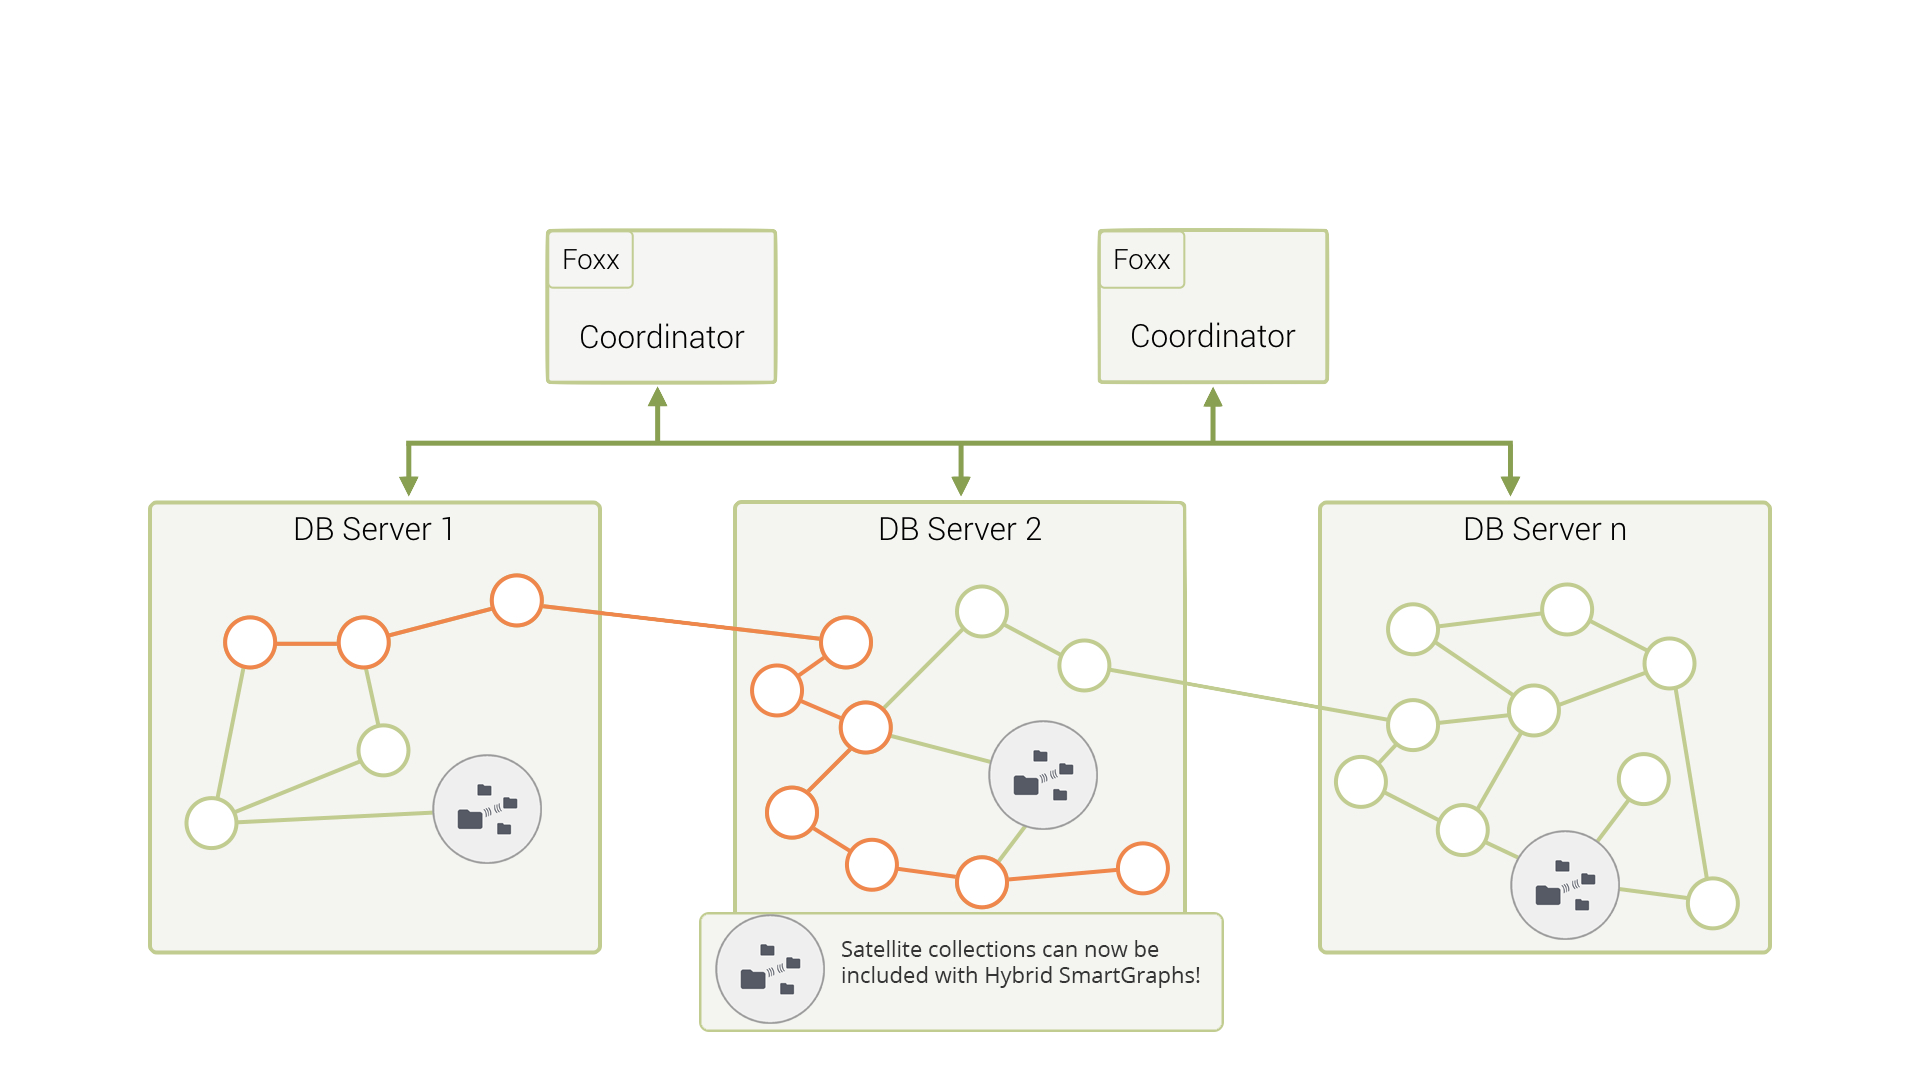

## Setup
The following code blocks setup our example by:
* Downloading a small LDBC sample dataset
* Downloads the latest ArangoDB 3.9 client tools
* Gets the import used to setup the Hybrid SmartGraphs and import data
* Finally, we set up the temporary tutorial database and import data

After the setup, continue reading on to learn more about Hybrid SmartGraphs and for a detailed explanation on the necessary SmartGraph creation process.

### Downloads a small LDBC sample dataset

This dataset contains relations between people, posts, comments, friends, likes, forums, and more. There are many different relationship types that make up this graph but for this example we will focus on importing this data as a SmartGraph.

This notebook creates a temporary tutorial database that you can play around in to explore the graph data in more detail as well.

In [ ]:
%%capture
%cd /content/
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av interactive_tutorials/ ./ --exclude=.git
!chmod -R 755 ./tools
!git clone -b hybrid-SmartGraphs --single-branch https://github.com/arangodb/interactive_tutorials.git hybrid-SmartGraphs
!rsync -av hybrid-SmartGraphs/ ./data

In [ ]:
%%capture
%cd /content/
!unzip "./data/social-network-sf0.003-interactive-composite-merged-fk.zip"

### Downloads the latest ArangoDB 3.9 client tools

In [ ]:
%%capture
%cd /content/
!wget https://download.arangodb.com/9c169fe900ff79790395784287bfa82f0dc0059375a34a2881b9b745c8efd42e/arangodb39-rc.1/Enterprise/Linux/arangodb3e-client-linux-3.9.0-rc.1.tar.gz
!tar -xvzf /content/arangodb3e-client-linux-3.9.0-rc.1.tar.gz

## Copies import script to data location

In [ ]:
%%capture
%cd /content/
!chmod 755 ./data/import_hybrid.sh
!cp ./data/import_hybrid.sh ./social-network-sf0.003-interactive-composite-merged-fk/graphs/csv/interactive/composite-merged-fk/import_hybrid.sh

### Sets up the temporary tutorial database

In [ ]:
%%capture
!pip3 install pyarango
!pip3 install "python-arango>=5.0"
!sudo apt-get install jq

In [ ]:
import os
import oasis
import json
from pyArango.connection import *
from arango import ArangoClient

# Retrieve tmp credentials from ArangoDB Tutorial Service

login = oasis.getTempCredentials(tutorialName="HybridSmartGraph")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch

database = oasis.connect_python_arango(login)

os.environ['ARANGODB_USERNAME']=login['username']
os.environ['ARANGODB_PASSWORD']=login['password']
os.environ['ARANGODB_DBNAME']=login['dbName']
os.environ['ARANGODB_HOSTNAME']="http+ssl://"+login["hostname"]+":"+str(login["port"])

No traceback available to show.


### Import the data

This script is an example of using arangoimport to import data from CSV. This is just one approach and you could always do more or less in the script vs using AQL for some post-processing. 

Feel free to view the script yourself and we will take a look at the pieces relevant to SmartGraph creation later in this notebook.

#### Note: We aren't done just yet
Continue reading to see an example of using AQL to post-process data for SmartGraphs.

In [ ]:
%%capture
%cd /content/social-network-sf0.003-interactive-composite-merged-fk/graphs/csv/interactive/composite-merged-fk
!ARANGO_ENDPOINT=$ARANGODB_HOSTNAME ARANGO_USERNAME=$ARANGODB_USERNAME ARANGO_PASSWORD=$ARANGODB_PASSWORD ARANGO_DATABASE=$ARANGODB_DBNAME DATA_DIR=/content/social-network-sf0.003-interactive-composite-merged-fk/graphs/csv/interactive/composite-merged-fk ARANGOIMPORT=/content/arangodb3e-client-linux-3.9.0-rc.1/bin/arangoimport ARANGOSH=/content/arangodb3e-client-linux-3.9.0-rc.1/bin/arangosh JAVASCRIPT_DIRECTORY=/content/arangodb3e-client-linux-3.9.0-rc.1/usr/share/arangodb3/js ./import_hybrid.sh

# What are SmartGraphs?

SmartGraphs are an Enterprise feature specifically targeted at graphs that need scalability and performance. SmartGraphs are 'smart' because of how they take advantage of ArangoDB cluster sharding. 

Typically, when you shard your data with ArangoDB the goal is even distribution of data across multiple servers. This approach can allow for scaling out your data and for many use cases is still quite fast. However, since one of the best features of ArangoDB is fast graph traversals, this sort of distribution can start causing problems as your data grows.  

For example, reviewing the image below shows what would be considered an acceptable solution for a non-graph distribution but once you start connecting the nodes to each other, it becomes clear that the graph traversal might need to travel across every server before returning results. This sort of traversal results in many network hops between servers, coordinators, and you. 




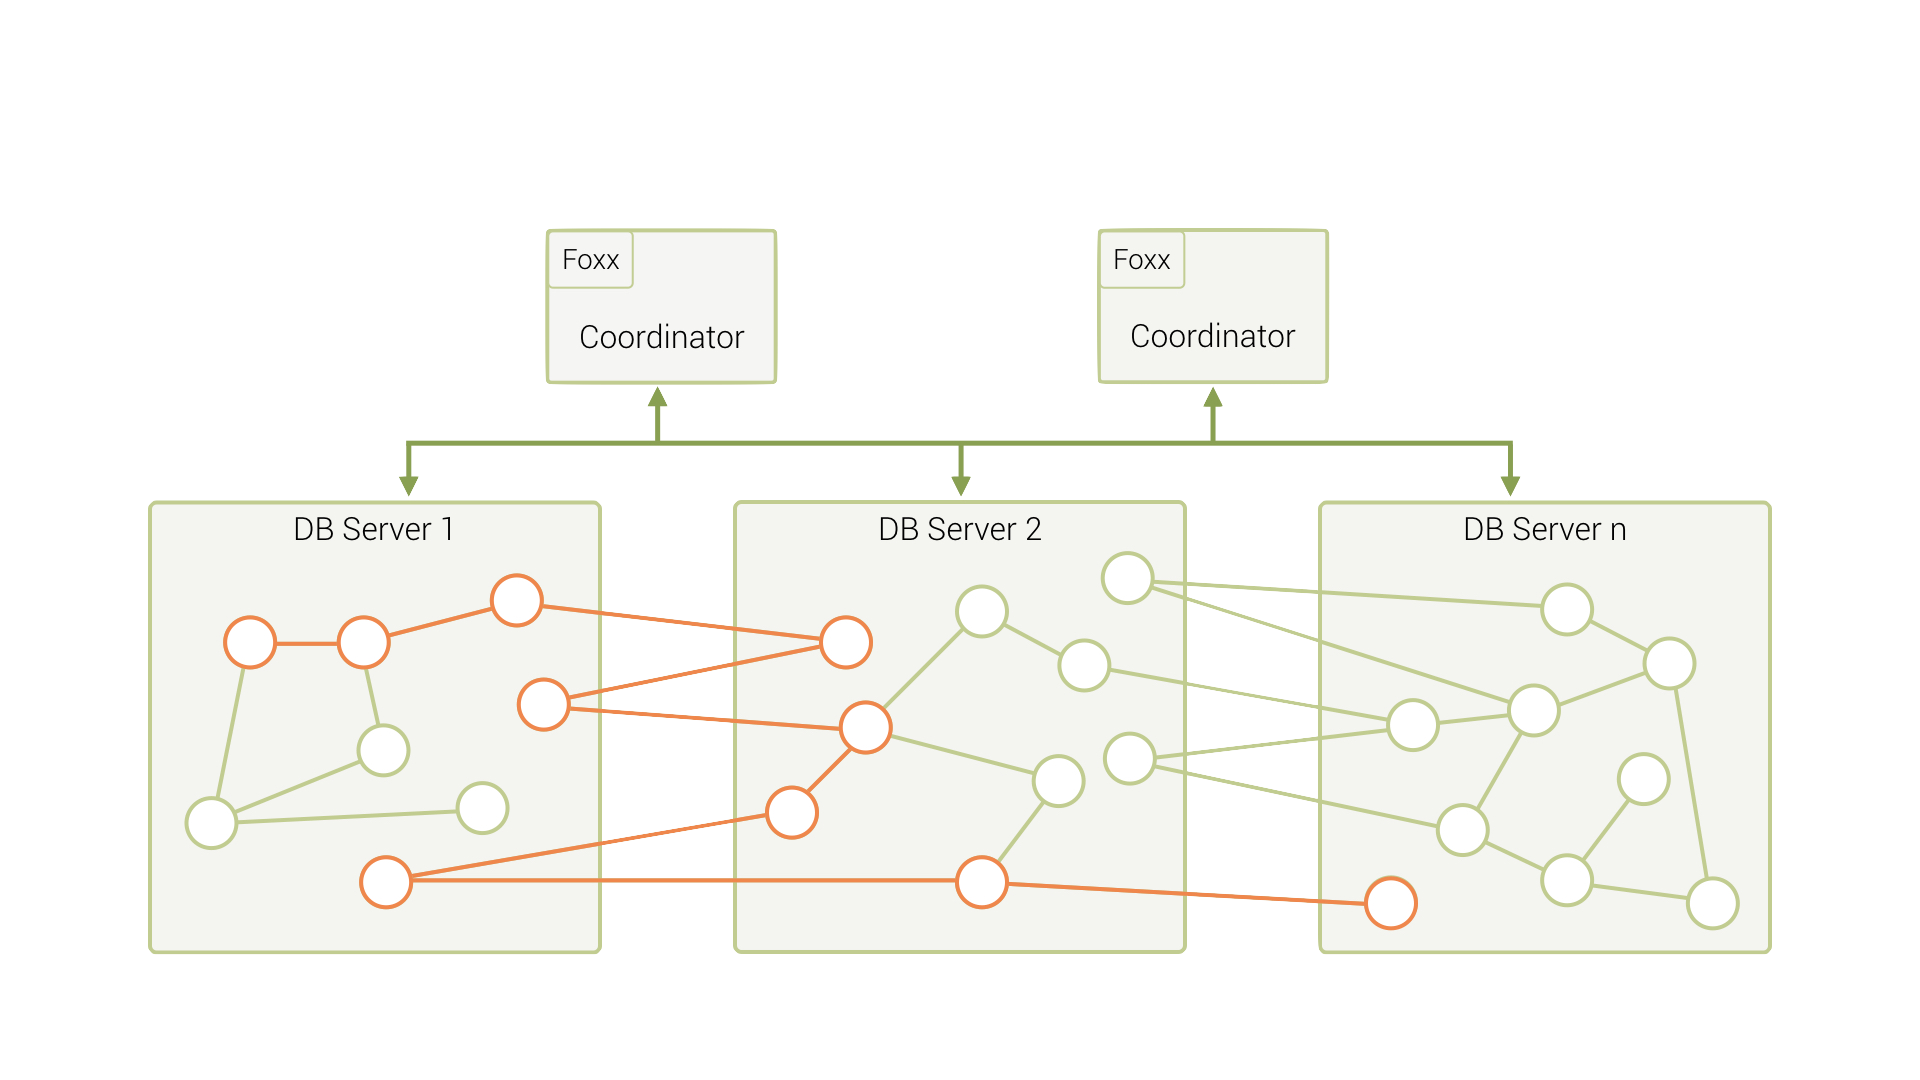

*The orange line indicates an example graph traversal. Notice how it touches nodes on every server.*

## How SmartGraphs solve the problem

With SmartGraphs we are able to leverage some of the natural patterns that exists in graph networks or that might arise from your client application query needs.

SmartGraphs come with a concept of a `smartGraphAttribute` that is used to inform the database how exactly to shard data. 

The example data we imported above centers around the people that participate on forums. So, the id of those people makes a great candidate for our `smartGraphAttribute`, since it is associated with so many collections. Sharding with this attribute means that the data that is relevant is now co-located on servers, whenever possible. So, if I want to lookup the posts or comments of a person and their friends or even friends of friends, that could potentially happen all on one or only a few servers (depending on data size). 

The GIF below shows exactly what the outcome of this smart sharding looks like.

![](https://www.arangodb.com/wp-content/uploads/2016/10/ArangoDB_SmartGraphs_Animation.gif)


### The outcome of moving the data like this is that you retain the scalability as well as the performance of graph traversals in ArangoDB.

### SmartGraph Keys

With SmartGraphs the keys used for sharding the data must result in the `smartGraphAttributeKey:standardKeyIdentifier` format. 

Example Person document: 
```
{
  'CreatorPersonId': '123', //our smart graph attribute
  'name': 'Chris',
  '_key': '123:123' // the second number could also be autogenerated
}
```

The reason the `_key` values are structed this way is that under the hood this informs the database on how to shard the document. For this example since the `smartGraphAttribute` is `CreatorPersonId` it isn't super relevant. However, the following example indicates that the `Post` associated with `CreatorPersonId` will now be sharded with it's author.  

Example Post document: 
```
{
  'CreatorPersonId': '123',
  'PostId': 'abc',
  '_key': '123:abc'
}
```
When using `smartKeys` it is often helpful to make intentional choices for the second `_key` identifier. The `_key` values are still indexed like normal so this value can become even more useful. For instance using the above example you have a relation between `Chris` and a `Post` the `Post` `_key`.

Now, you only need to perform a single indexed `_key` lookup to have the information for the Post author and Post Id. These sorts of benefits will vary depending on use case.


#### SmartGraph Edge Keys

SmartGraph edges have an additional `_key` element and just like with document `_keys` this is useful for informing where the edges should exist. The structure for smart edges is:

 `smartGraphAttributeFROM:autoGeneratedKey:smartGraphAttributeTO`

The middle key is handled automatically when you define the `_from` and `_to` attributes.

### Hybrid SmartGraph Edge Keys
Since Hybrid SmartGraphs allow for including satellite collections this three key approach is not necessary, since all satellite collections are already co-located. Their `_key` structure looks like the normal SmartGraph `_key` values. 
Example Hybrid SmartGraph Edge:

```
{
  '_from': '123:123',
  '_to': 'xyz:xyz',
  '_key': '123:random'
}
```
Furthermore, if both collections that exist as a part of the SmartGraph are satellite collections the `_key` value is standard `_key`.

Example Edge with Satellites on both side:
```
{
  '_from': 'sat1:sat1',
  '_to': 'sat2:sat2',
  '_key': 'random'
}
```

# What are Hybrid SmartGraphs?

Hybrid SmartGraphs are a new feature addition introduces in ArangoDB 3.9 Enterprise Edition. It is a simple but powerful (optional) addition to SmartGraphs, the ability to use SatelliteCollections within the SmartGraph definition. 

This means that edge definitions defined between SmartCollections and SatelliteCollections can be created. As SatelliteCollections (and the edge collections between SmartGraph collections and SatelliteCollection) are globally replicated to each participating DB-Server, (weighted) graph traversals and (k-)shortest path(s) queries can partially be executed locally on each DB-Server. 

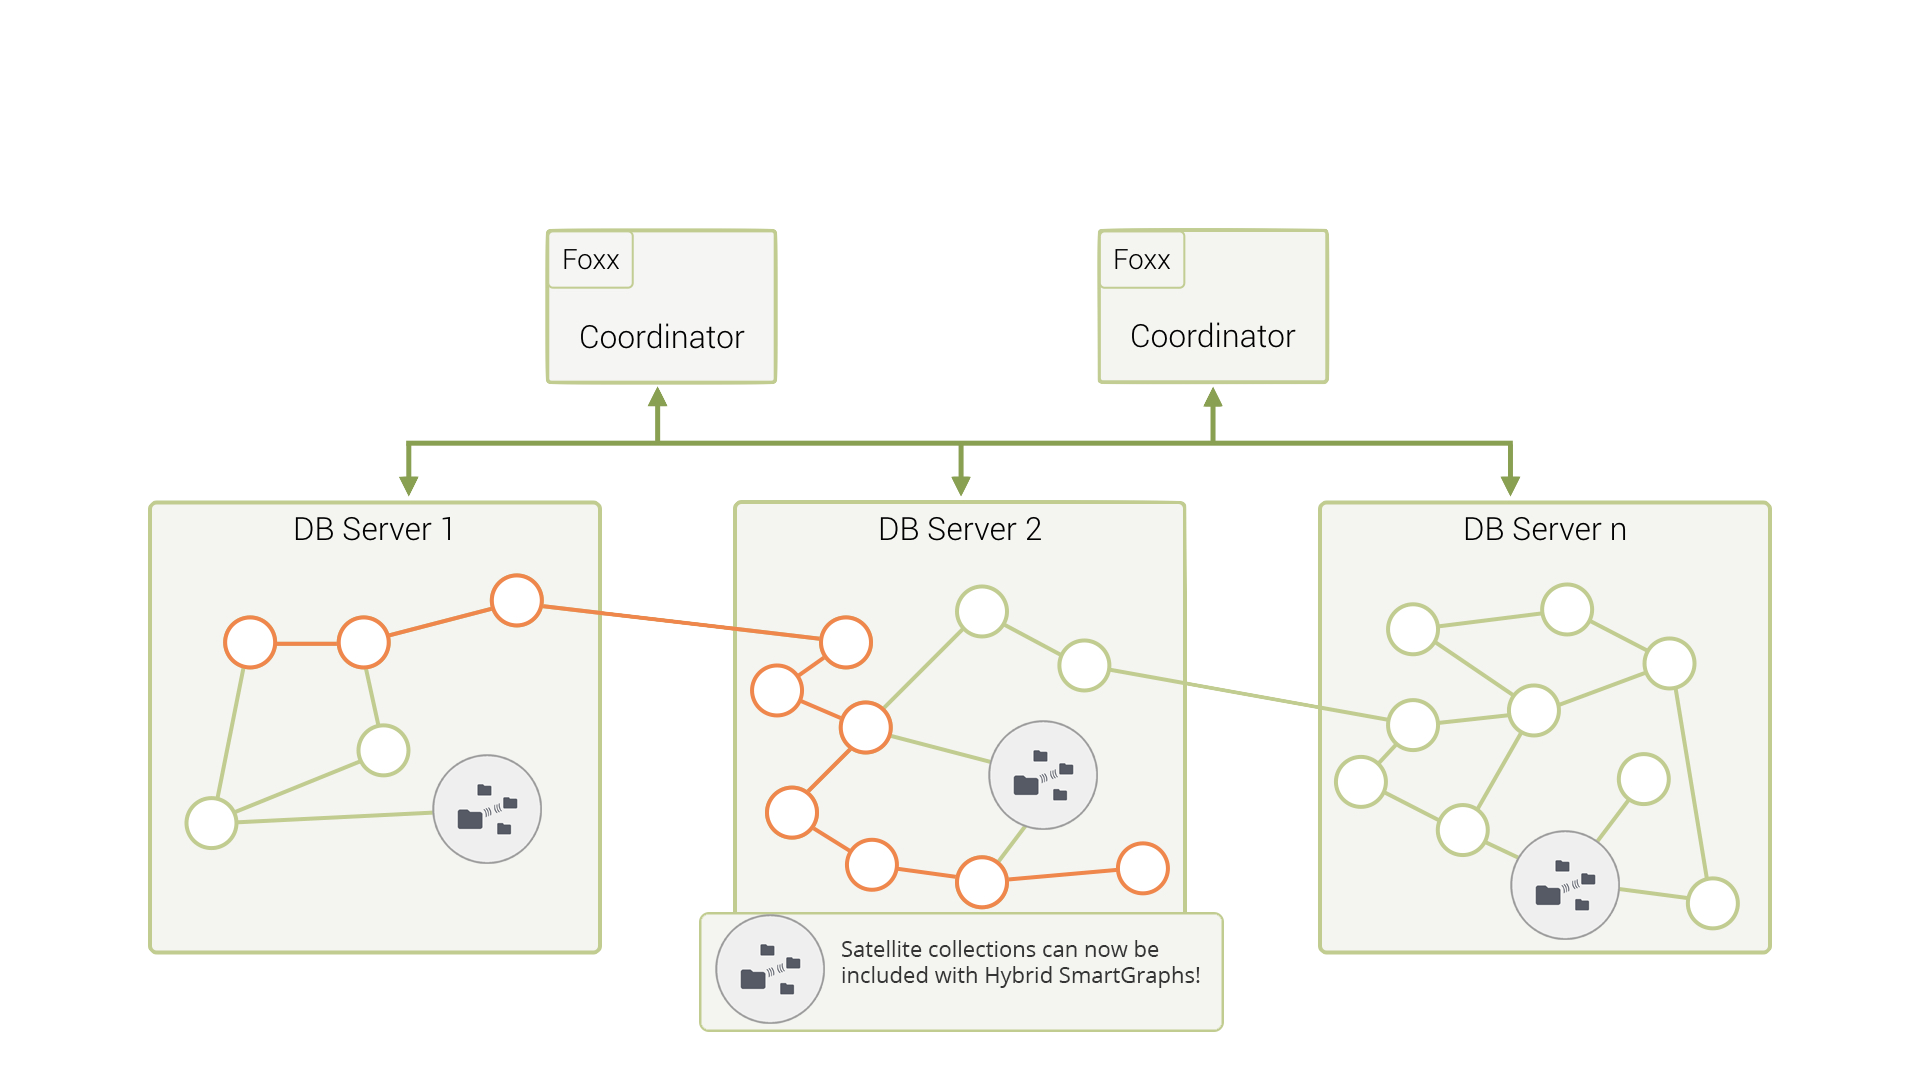


### The benefit of this is that a larger part of the query can be executed fully local whenever data from the SatelliteCollections is required.

# Creating a Hybrid SmartGraph

This section will discuss how we created the Hybrid SmartGraph and the considerations necessary for SmartGraphs and the changes required to allow for including satellite collections.


---



When compared to standard SmartGraphs the changes involved are minimal. The most notable addition to the SmartGraph creation process is that you now can define the satellite collections as a part of the SmartGraph definition.

For example, we defined the graph used in this example with the following:
```
  graph_module._create("ldbc", rel, [], {"numberOfShards": 3, "smartGraphAttribute": "CreatorPersonId", "satellites":["Tag", "TagClass", "Organisation", "University", "Forum"]});

```

Now, when defining the relations of our SmartGraph, the collections listed as `satellites` will have local edge collections created and the satellite collections will be distributed across the database servers, just like normal satellite collections.

Here is an example of defining a SmartGraph relation that included a satellite collection `Tag`:
```
  rel.push(graph_module._relation("Comment_hasTag_Tag", ["Comment"], ["Tag"]));

```

You can see the full script that was used for importing this data from csv [HERE](https://github.com/arangodb/interactive_tutorials/blob/hybrid-SmartGraphs/import_hybrid.sh)

Note, that this script uses the latest version of arangoimport which comes with the new `--merge-attributes` functionality. This allows us to easily set the `_key` value to the `smartKey:uniqueKeyIdentifier` format necessary for SmartGraphs during import instead of after.

The satellite collections that we imported are:
* Tag
* TagClass
* Organisation
* University
* Forum


### SmartGraph Considerations

### Post-Processing with AQL 

Once the data is imported we have a few collections that we didn't pre-process. How you decide to get your `_key` values into proper format is completely up to you. With large amounts of data it may be easier for you to do this in advance. However, for our small example with only a few collections to update, we will use the wonderful AQL! 😀🥑

This challenge that came across was that we smartified Posts, Comments, and Tags. We also have relations for Posts and comments have tags and also people like those posts and comments. Since our source files didn't contain the necessary author id for these things we just do a quick lookup to know what the new `_key` values are for our comments and posts. 

This is something to keep in mind when migrating to SmartGraphs, the relations you have will likely need to have their `_from` and `_to` attributes updated. While we are able to do simple things like change a Person key of `_key: 123` to `_key: 123:123`, we can't do the same for a person who like a comment. As originally this comment `_key` was `_key: abc` but its smart key value is `_key: commentAuthor:CommentId` or `_key: 456:abc`. 

This is a simple lookup in the Comment collection to grab the smartified comment id and then update our edge collections.

In [ ]:
standardCollections = [["Comment_hasTag_Tag_standard", "Comment", "CommentId", "_from"], ["Post_hasTag_Tag_standard", "Post", "PostId", "_from"],["Person_likes_Comment_standard", "Comment", "CommentId", "_to"], ["Person_likes_Post_standard","Post", "PostId", "_to"]]

for item in standardCollections:
  print("Smartifying: ", item[0])  
  results = database.aql.execute(
      """  
      FOR edgeDoc IN @@standardCollectionName
        FOR parentDoc IN @@parentCollection
          FILTER parentDoc.id == edgeDoc.@idType
          LET sys = {@direction: CONCAT(parentDoc._id)}
          LET a = UNSET(edgeDoc, ["_key", "_id", "_rev",@direction])
          INSERT MERGE(sys, a) INTO @@SmartEdgeCollection
      """, 
      bind_vars={
          '@standardCollectionName': item[0],
          '@parentCollection': item[1],
          'idType': item[2],
          'direction': item[3],
          '@SmartEdgeCollection': item[0].rsplit('_', 1)[0]
          })
  database.delete_collection(item[0]) # remove non-smart collection

print("Smartifying complete!")

Smartifying:  Comment_hasTag_Tag_standard
Smartifying:  Post_hasTag_Tag_standard
Smartifying:  Person_likes_Comment_standard
Smartifying:  Person_likes_Post_standard
Smartifying complete!


This query also drops the old collection once it is complete. 

You now have a fully smartified Hybrid SmartGraph that is running on Oasis. Feel free to check it out for yourself!

# Conclusion

This notebook has shown you how to create a Hybrid SmartGraph. While there are a lot of benefits with being able to use satellite collections in your SmartGraphs, as you can now see, it only involves a small change when creating your SmartGraph. 

The key takeaway is how we used the graph module commands to create our SmartGraph. However, this creation process can also be done via the ArangoDB Web Interface. To continue learning more about SmartGraphs be sure to visit the [documentation](https://www.arangodb.com/docs/3.9/graphs-smart-graphs.html) page for all of the different options available with SmartGraphs.

There are also a lot of other awesome features that came along with ArangoDB 3.9, so be sure to check out [What's New](https://www.arangodb.com/docs/3.9/release-notes-new-features39.html) in 3.9!

If you want to keep the party going after your tutorial instance expires you can sign up for a [free 14 day ArangoDB Oasis trial today](https://cloud.arangodb.com/home)!